# Dask tutorial

Source: https://github.com/TomAugspurger/dask-tutorial-pycon-2018/blob/master/01-dask.delayed.ipynb

In [25]:

import os
import numpy as np
import pandas as pd
import tarfile
import urllib.request
import zipfile
from glob import glob

data_dir = 'data'


def flights():
    flights_raw = os.path.join(data_dir, 'nycflights.tar.gz')
    flightdir = os.path.join(data_dir, 'nycflights')
    jsondir = os.path.join(data_dir, 'flightjson')

    if not os.path.exists(data_dir):
        os.mkdir(data_dir)

    if not os.path.exists(flights_raw):
        print("- Downloading NYC Flights dataset... ", end='', flush=True)
        url = "https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz"
        urllib.request.urlretrieve(url, flights_raw)
        print("done", flush=True)

    if not os.path.exists(flightdir):
        print("- Extracting flight data... ", end='', flush=True)
        tar_path = os.path.join('data', 'nycflights.tar.gz')
        with tarfile.open(tar_path, mode='r:gz') as flights:
            flights.extractall('data/')
        print("done", flush=True)

    if not os.path.exists(jsondir):
        print("- Creating json data... ", end='', flush=True)
        os.mkdir(jsondir)
        for path in glob(os.path.join('data', 'nycflights', '*.csv')):
            prefix = os.path.splitext(os.path.basename(path))[0]
            # Just take the first 10000 rows for the demo
            df = pd.read_csv(path).iloc[:10000]
            df.to_json(os.path.join('data', 'flightjson', prefix + '.json'),
                       orient='records', lines=True)
        print("done", flush=True)

    print("** Finished! **")


def random_array():
    if os.path.exists(os.path.join('data', 'random.hdf5')):
        return

    print("Create random data for array exercise")
    import h5py

    with h5py.File(os.path.join('data', 'random.hdf5')) as f:
        dset = f.create_dataset('/x', shape=(1000000000,), dtype='f4')
        for i in range(0, 1000000000, 1000000):
            dset[i: i + 1000000] = np.random.exponential(size=1000000)


def weather(growth=3200):
    url = 'https://storage.googleapis.com/dask-tutorial-data/weather-small.zip'
    weather_zip = os.path.join('data', 'weather-small.zip')
    weather_small = os.path.join('data', 'weather-small')

    if not os.path.exists(weather_zip):
        print("Downloading weather data.")
        urllib.request.urlretrieve(url, weather_zip)

    if not os.path.exists(weather_small):
        print("Extracting to {}".format(weather_small))
        zf = zipfile.ZipFile(weather_zip)
        zf.extractall(data_dir)

    filenames = sorted(glob(os.path.join('data', 'weather-small', '*.hdf5')))

    if not os.path.exists(os.path.join('data', 'weather-big')):
        os.mkdir(os.path.join('data', 'weather-big'))

    if all(os.path.exists(fn.replace('small', 'big')) for fn in filenames):
        return

    from skimage.transform import resize
    import h5py

    for fn in filenames:
        with h5py.File(fn, mode='r') as f:
            x = f['/t2m'][:]

        new_shape = tuple(s * growth // 100 for s in x.shape)

        y = resize(x, new_shape, mode='constant')

        out_fn = os.path.join('data', 'weather-big', os.path.split(fn)[-1])

        try:
            with h5py.File(out_fn) as f:
                f.create_dataset('/t2m', data=y, chunks=(500, 500))
        except:
            pass


def main():
    print("Setting up data directory")
    print("-------------------------")

    flights()
    random_array()
    weather()

main()

Setting up data directory
-------------------------
- Downloading NYC Flights dataset... done
- Extracting flight data... done
- Creating json data... done
** Finished! **
Create random data for array exercise
Extracting to data/weather-small


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [5]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 703 µs, sys: 539 µs, total: 1.24 ms
Wall time: 3 s


In [6]:
from dask import delayed

In [7]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 759 µs, sys: 0 ns, total: 759 µs
Wall time: 650 µs


In [8]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 8.02 ms, sys: 6.84 ms, total: 14.9 ms
Wall time: 2.01 s


5

In [9]:
z

Delayed('add-64f67746-d57c-4347-829b-8a53c379807c')

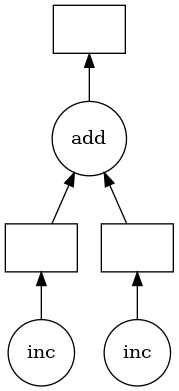

In [10]:
z.visualize()

In [11]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [12]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 9.8 ms, sys: 2.31 ms, total: 12.1 ms
Wall time: 8.01 s


In [13]:
total

44

CPU times: user 4.11 ms, sys: 5.7 ms, total: 9.81 ms
Wall time: 1.01 s


In [14]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [18]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
CPU times: user 13.1 ms, sys: 2.82 ms, total: 15.9 ms
Wall time: 10 s


In [22]:
%%time
results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
total.compute()

CPU times: user 6.45 ms, sys: 3.47 ms, total: 9.92 ms
Wall time: 1.01 s


90

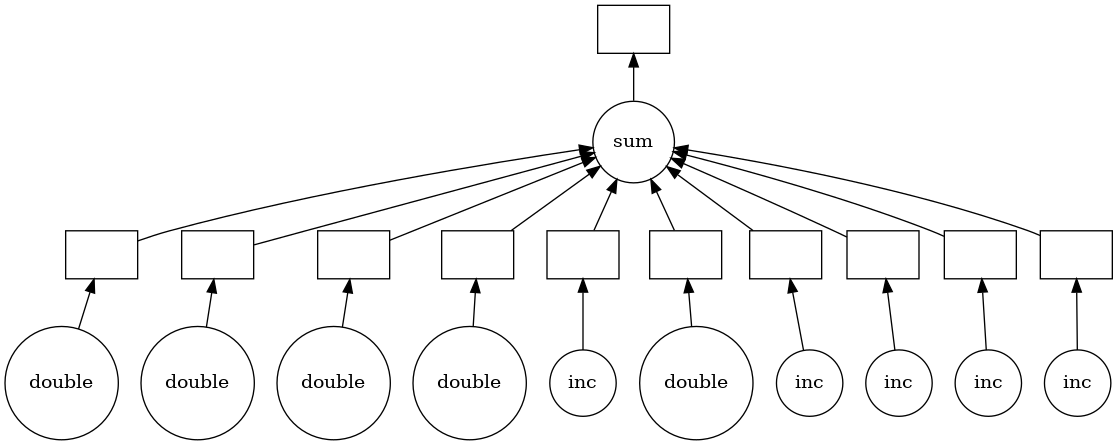

In [23]:
total.visualize()

In [26]:
import os
sorted(os.listdir(os.path.join('data', 'nycflights')))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

In [27]:
import pandas as pd
df = pd.read_csv(os.path.join('data', 'nycflights', '1990.csv'))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [28]:
# What is the schema?
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
dtype: object

In [29]:
# What originating airports are in the data?
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [30]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

In [31]:
from glob import glob
filenames = sorted(glob(os.path.join('data', 'nycflights', '*.csv')))

In [32]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 3.78 s, sys: 108 ms, total: 3.88 s
Wall time: 3.88 s


In [35]:
from dask import compute

In [42]:
%%time
# This is just one possible solution, there are
# several ways to do this using `delayed`

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
sums, counts = compute(sums, counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights
mean

CPU times: user 8.74 s, sys: 905 ms, total: 9.64 s
Wall time: 2.49 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [45]:
import numpy as np

In [46]:
%%time 
x = np.random.normal(10, 0.1, size=(20000, 20000)) 
y = x.mean(axis=0)[::100] 
y

CPU times: user 12.4 s, sys: 641 ms, total: 13 s
Wall time: 13 s


array([10.0009622 ,  9.99975137,  9.99909639, 10.00071883,  9.99996498,
        9.99941911,  9.99998512, 10.00065612,  9.99962228, 10.00025014,
        9.99994883,  9.99944445,  9.99918978, 10.00007859, 10.00030621,
       10.00022579,  9.99995454, 10.00008729,  9.99880964, 10.00017082,
        9.99925787,  9.99926094, 10.00014083,  9.99992087, 10.00043321,
       10.00083434,  9.99957247,  9.99961161, 10.00074676, 10.00115672,
       10.00114454, 10.00127374, 10.0005903 , 10.00072834, 10.00027517,
        9.99995724,  9.99962507,  9.99893836, 10.00013759,  9.99969488,
       10.00172933,  9.99897576,  9.99926424,  9.99986265,  9.99947278,
        9.99913397, 10.00001932, 10.0008254 , 10.00066765, 10.00111108,
       10.00017706,  9.99940429, 10.00015297,  9.99957145,  9.99937318,
       10.00007449, 10.00000303, 10.00093899, 10.00156076, 10.00073997,
       10.00072618, 10.00013396,  9.99961067, 10.00048082, 10.00017967,
        9.99857945, 10.00046014, 10.00040787, 10.00003958,  9.99

In [47]:
import dask.array as da

In [48]:
%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::100] 
y.compute() 

CPU times: user 16.3 s, sys: 161 ms, total: 16.4 s
Wall time: 1.23 s


array([ 9.99967172,  9.99986127,  9.99967943,  9.99884289, 10.00024356,
        9.9997172 , 10.00162638, 10.00107299,  9.99927771, 10.00057381,
       10.00020414,  9.99999388, 10.00100552, 10.00090939,  9.99985319,
       10.00103203, 10.00057946,  9.99921445,  9.99970877, 10.00069494,
       10.00061736,  9.99887437,  9.99892662,  9.99936792,  9.99923106,
        9.99956308, 10.00068285,  9.9996287 , 10.00008683, 10.00025416,
        9.99978043,  9.99867045, 10.00104916, 10.00023934, 10.00015627,
        9.99983346,  9.99927572,  9.99918598,  9.99894699, 10.00067995,
        9.9998378 , 10.0010007 , 10.00108598, 10.0001682 , 10.00053544,
       10.00023407,  9.99924399, 10.00108296,  9.99907675, 10.00048715,
        9.99896009,  9.99925394, 10.0002894 ,  9.99935915, 10.00044338,
        9.99965377, 10.00027864,  9.99947075, 10.00021255, 10.0004376 ,
       10.0006688 ,  9.99894583,  9.99912243,  9.99999834, 10.000122  ,
        9.9996821 , 10.00094363,  9.99926135,  9.99977905, 10.00

In [49]:
import h5py
from glob import glob
import os

filenames = sorted(glob(os.path.join('data', 'weather-big', '*.hdf5')))
dsets = [h5py.File(filename, mode='r')['/t2m'] for filename in filenames]
dsets[0]

<HDF5 dataset "t2m": shape (5760, 11520), type "<f8">

In [50]:
dsets[0][:5, :5]  # Slicing into h5py.Dataset object gives a numpy array

array([[22.53240967, 23.89801025, 25.26361084, 26.62921143, 27.99481201],
       [23.89801025, 25.34637451, 26.79473877, 28.24310303, 29.69146729],
       [25.26361084, 26.79473877, 28.3258667 , 29.85699463, 31.38812256],
       [26.62921143, 28.24310303, 29.85699463, 31.47088623, 33.08477783],
       [27.99481201, 29.69146729, 31.38812256, 33.08477783, 34.78143311]])

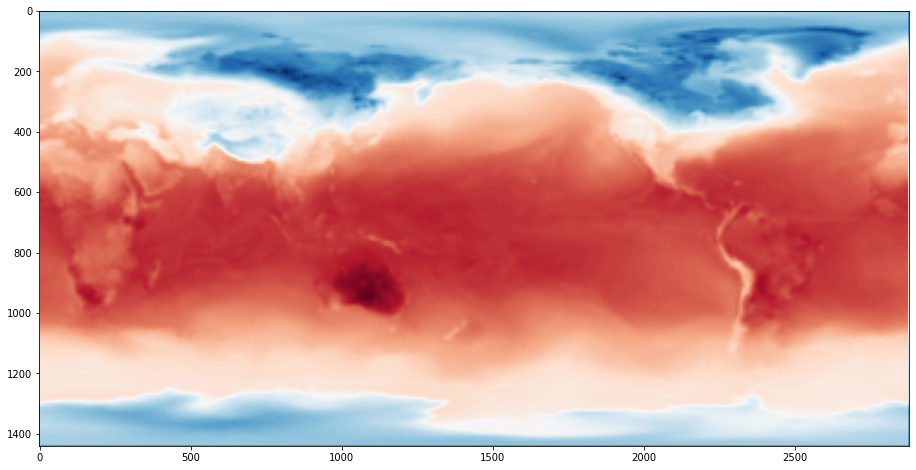

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
plt.imshow(dsets[0][::4, ::4], cmap='RdBu_r')

In [52]:
arrays = [da.from_array(dset, chunks=(500, 500)) for dset in dsets]
arrays

[dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize

In [55]:
x = da.stack(arrays, axis=0)
x

,Array,Chunk
Bytes,16.46 GB,2.00 MB
Shape,"(31, 5760, 11520)","(1, 500, 500)"
Count,17887 Tasks,8928 Chunks
Type,float64,numpy.ndarray


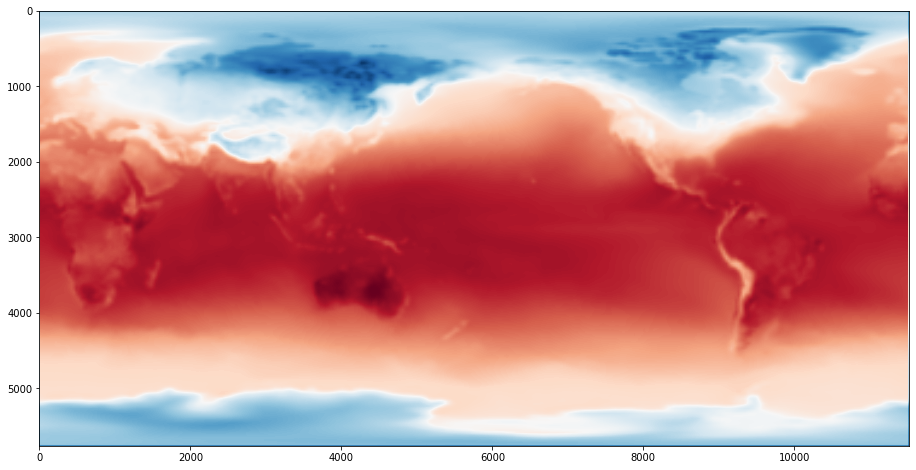

In [56]:
result = x.mean(axis=0)
fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap='RdBu_r')

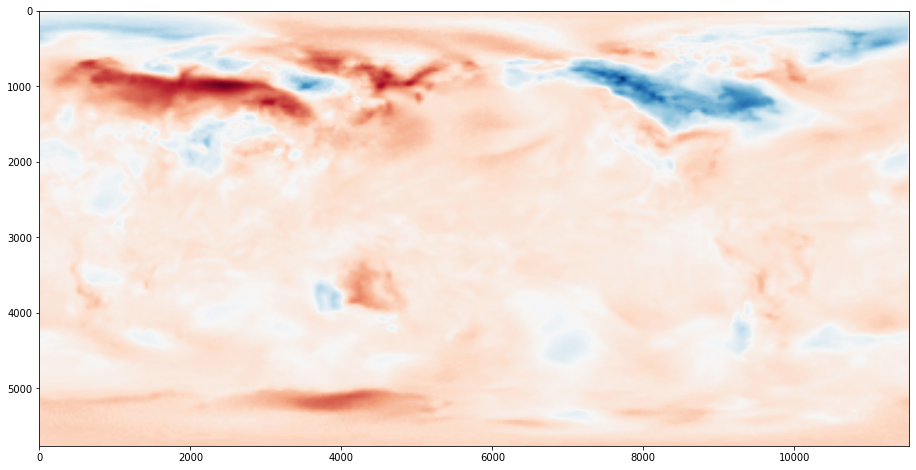

In [57]:
result = x[0] - x.mean(axis=0)
fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap='RdBu_r')

In [58]:
result = x[:, ::2, ::2]
da.to_hdf5(os.path.join('data', 'myfile.hdf5'), '/output', result)

In [59]:
import numpy as np

# make a random collection of particles
def make_cluster(natoms, radius=40, seed=1981):
    np.random.seed(seed)
    cluster = np.random.normal(0, radius, (natoms,3))-0.5
    return cluster

def lj(r2):
    sr6 = (1./r2)**3
    pot = 4.*(sr6*sr6 - sr6)
    return pot

# build the matrix of distances
def distances(cluster):
    diff = cluster[:, np.newaxis, :] - cluster[np.newaxis, :, :]
    mat = (diff*diff).sum(-1)
    return mat

# the lj function is evaluated over the upper traingle
# after removing distances near zero
def potential(cluster):
    d2 = distances(cluster)
    dtri = np.triu(d2)
    energy = lj(dtri[dtri > 1e-6]).sum()
    return energy

In [60]:
cluster = make_cluster(int(7e3), radius=500)

In [61]:
%time potential(cluster)


CPU times: user 2.54 s, sys: 1.02 s, total: 3.56 s
Wall time: 3.55 s


-0.21282893668845293

In [62]:
%prun -s cumulative potential(cluster)


         30 function calls in 3.526 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.526    3.526 {built-in method builtins.exec}
        1    0.031    0.031    3.526    3.526 <string>:1(<module>)
        1    0.209    0.209    3.495    3.495 <ipython-input-59-eee0a774211b>:22(potential)
        1    1.084    1.084    1.791    1.791 <ipython-input-59-eee0a774211b>:15(distances)
        1    1.320    1.320    1.320    1.320 <ipython-input-59-eee0a774211b>:9(lj)
        2    0.000    0.000    0.721    0.360 {method 'sum' of 'numpy.ndarray' objects}
        2    0.000    0.000    0.721    0.360 _methods.py:34(_sum)
        2    0.721    0.360    0.721    0.360 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.000    0.000    0.162    0.162 twodim_base.py:441(triu)
        1    0.140    0.140    0.140    0.140 {built-in method numpy.where}
        1    0.000    0.000    0.022    0.022 t

In [63]:
import dask.array as da

# compute the potential on the entire
# matrix of distances and ignore division by zero
def potential_dask(cluster):
    d2 = distances(cluster)
    energy = da.nansum(lj(d2))/2.
    return energy

In [64]:
from os import cpu_count

dcluster = da.from_array(cluster, chunks=cluster.shape[0]//cpu_count())

In [65]:
e = potential_dask(dcluster)
%time e.compute()

/opt/conda/lib/python3.6/site-packages/dask/array/core.py:3767: PerformanceWarning: Increasing number of chunks by factor of 17
  **blockwise_kwargs
/opt/conda/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/opt/conda/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*args2)


CPU times: user 6.06 s, sys: 29.2 ms, total: 6.09 s
Wall time: 509 ms


-0.2128289366884531

# Dask DataFrames
We finished the last section by building a parallel dataframe computation over a directory of CSV files using dask.delayed. In this section we use dask.dataframe to build computations for us in the common case of tabular computations. Dask dataframes look and feel like Pandas dataframes but they run on the same infrastructure that powers dask.delayed.
In this notebook we use the same airline data as in notebook 01, but now rather than write for loops we let dask.dataframe construct our computations for us. The dask.dataframe.read_csv function can take a globstring like "data/nycflights/*.csv" and build parallel computations on all of our data at once.
When to use dask.dataframe
Pandas is great for tabular datasets that fit in memory. Dask becomes useful when the dataset you want to analyze is larger than your machine's RAM. We didn't want to overwhelm the conference WiFi downloading large datasets, so the demo dataset we're working with is only about 200MB. But dask.dataframe will scale to larger than memory datasets.

In [66]:
import os

import dask
import dask.dataframe as dd
import pandas as pd

pd.options.display.max_rows = 10

df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]})

In [67]:
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [68]:
# Get the first 5 rows
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [69]:
# Get the last 5 rows
df.tail()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N54711'",)

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

### What just happened?

Unlike pandas.read_csv which reads in the entire file before inferring datatypes, dask.dataframe.read_csv only reads in a sample from the beginning of the file (or first file if using a glob). These inferred datatypes are then enforced when reading all partitions.

In this case, the datatypes inferred in the sample are incorrect. The first n rows have no value for CRSElapsedTime (which pandas infers as a float), and later on turn out to be strings (object dtype). When this happens you have a few options:

- Specify dtypes directly using the dtype keyword. This is the recommended solution, as it's the least error prone (better to be explicit than implicit) and also the most performant.
- Increase the size of the sample keyword (in bytes)
- Use assume_missing to make dask assume that columns inferred to be int (which don't allow missing values) are actually floats (which do allow missing values). In our particular case this doesn't apply.

In our case we'll use the first option and directly specify the dtypes of the offending columns.

In [70]:
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [71]:
df.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


## Computations with dask.dataframe
We compute the maximum of the DepDelay column. With just pandas, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums

```python
maxes = []
for fn in filenames:
    df = pd.read_csv(fn)
    maxes.append(df.DepDelay.max())

final_max = max(maxes)
```

We could wrap that pd.read_csv with dask.delayed so that it runs in parallel. Regardless, we're still having to think about loops, intermediate results (one per file) and the final reduction (max of the intermediate maxes). This is just noise around the real task, which pandas solves with

```python
df = pd.read_csv(filename, dtype=dtype)  
df.DepDelay.max()
```

dask.dataframe lets us write pandas-like code, that operates on larger than memory datasets in parallel.



In [72]:
%time df.DepDelay.max().compute()

CPU times: user 12 s, sys: 973 ms, total: 13 s
Wall time: 5.04 s


1435.0

This writes the delayed computation for us and then runs it.

Some things to note:

1. As with dask.delayed, we need to call .compute() when we're done. Up until this point everything is lazy.
2. Dask will delete intermediate results (like the full pandas dataframe for each file) as soon as possible.
  - This lets us handle datasets that are larger than memory
  - This means that repeated computations will have to load all of the data in each time (run the code above again, is it faster or slower than you would expect?)

As with Delayed objects, you can view the underlying task graph using the .visualize method:/
    

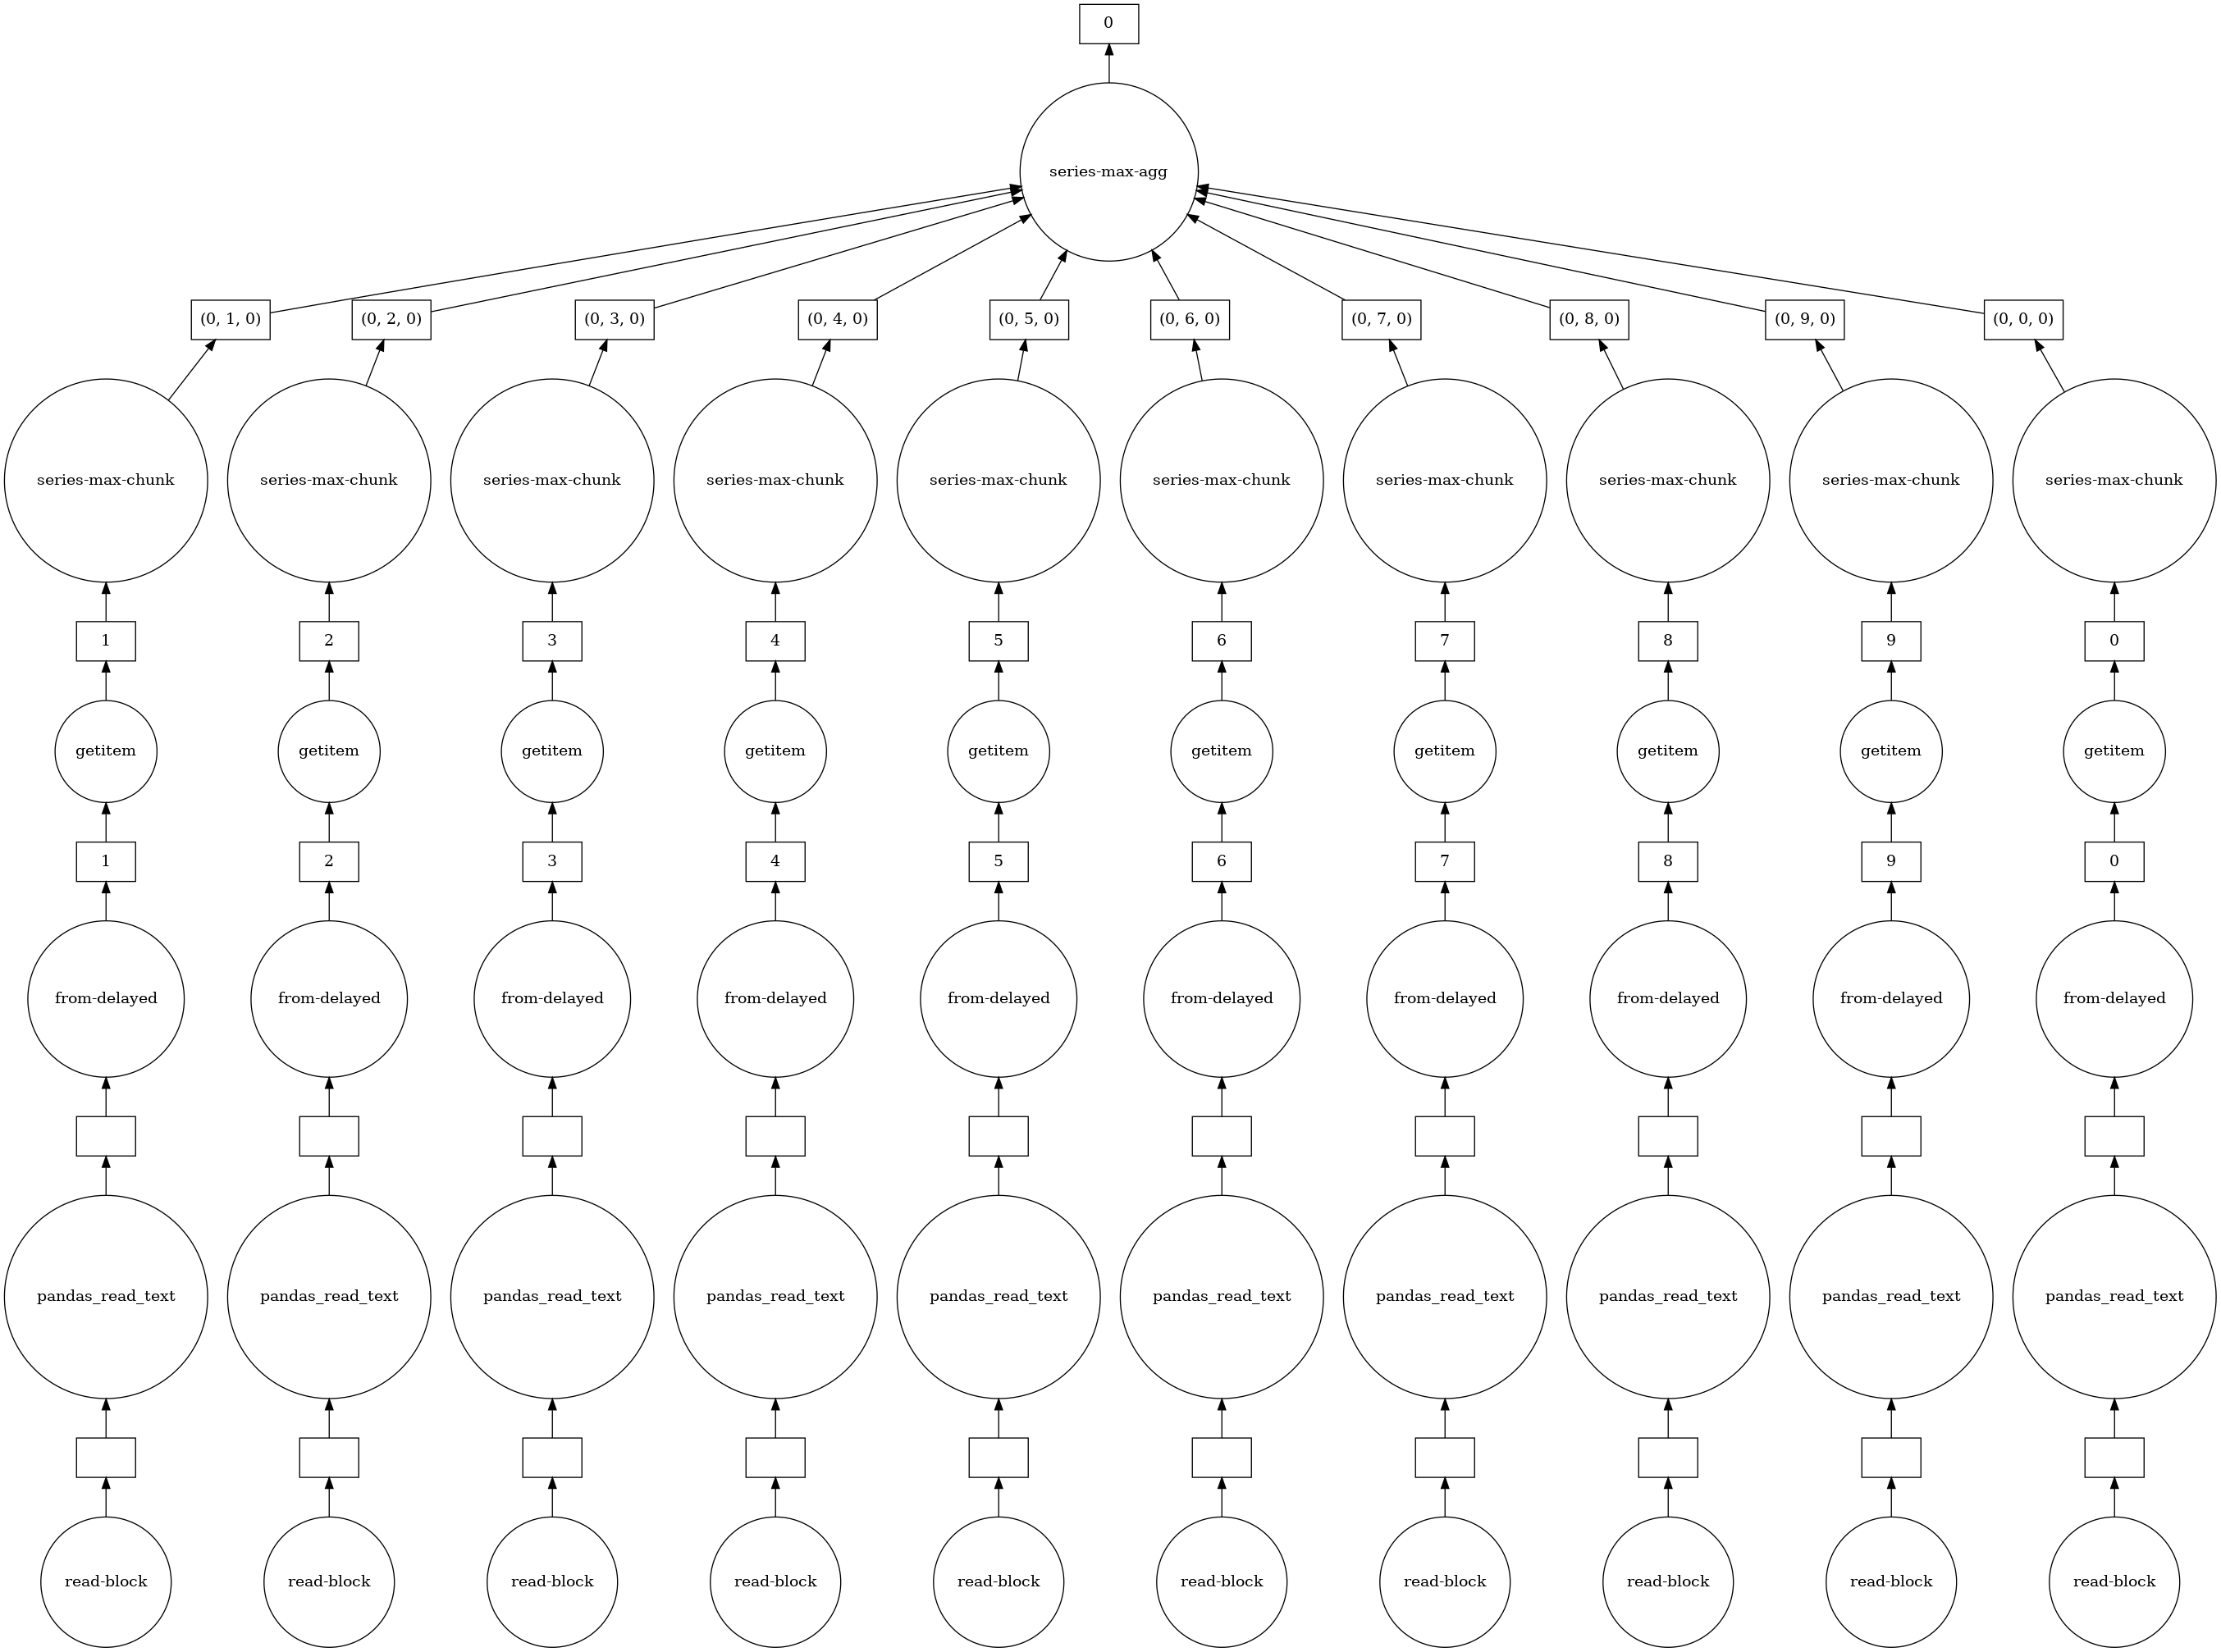

In [73]:
df.DepDelay.max().visualize()

# Exercises
In this section we do a few dask.dataframe computations. If you are comfortable with Pandas then these should be familiar. You will have to think about when to call compute.

## 1.) How many rows are in our dataset?
If you aren't familiar with pandas, how would you check how many records are in a list of tuples?

In [74]:
len(df)

2611892

In [78]:
len(df[~df.Cancelled])

2540961

In [82]:
df[~df.Cancelled].groupby('Origin').Origin.count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

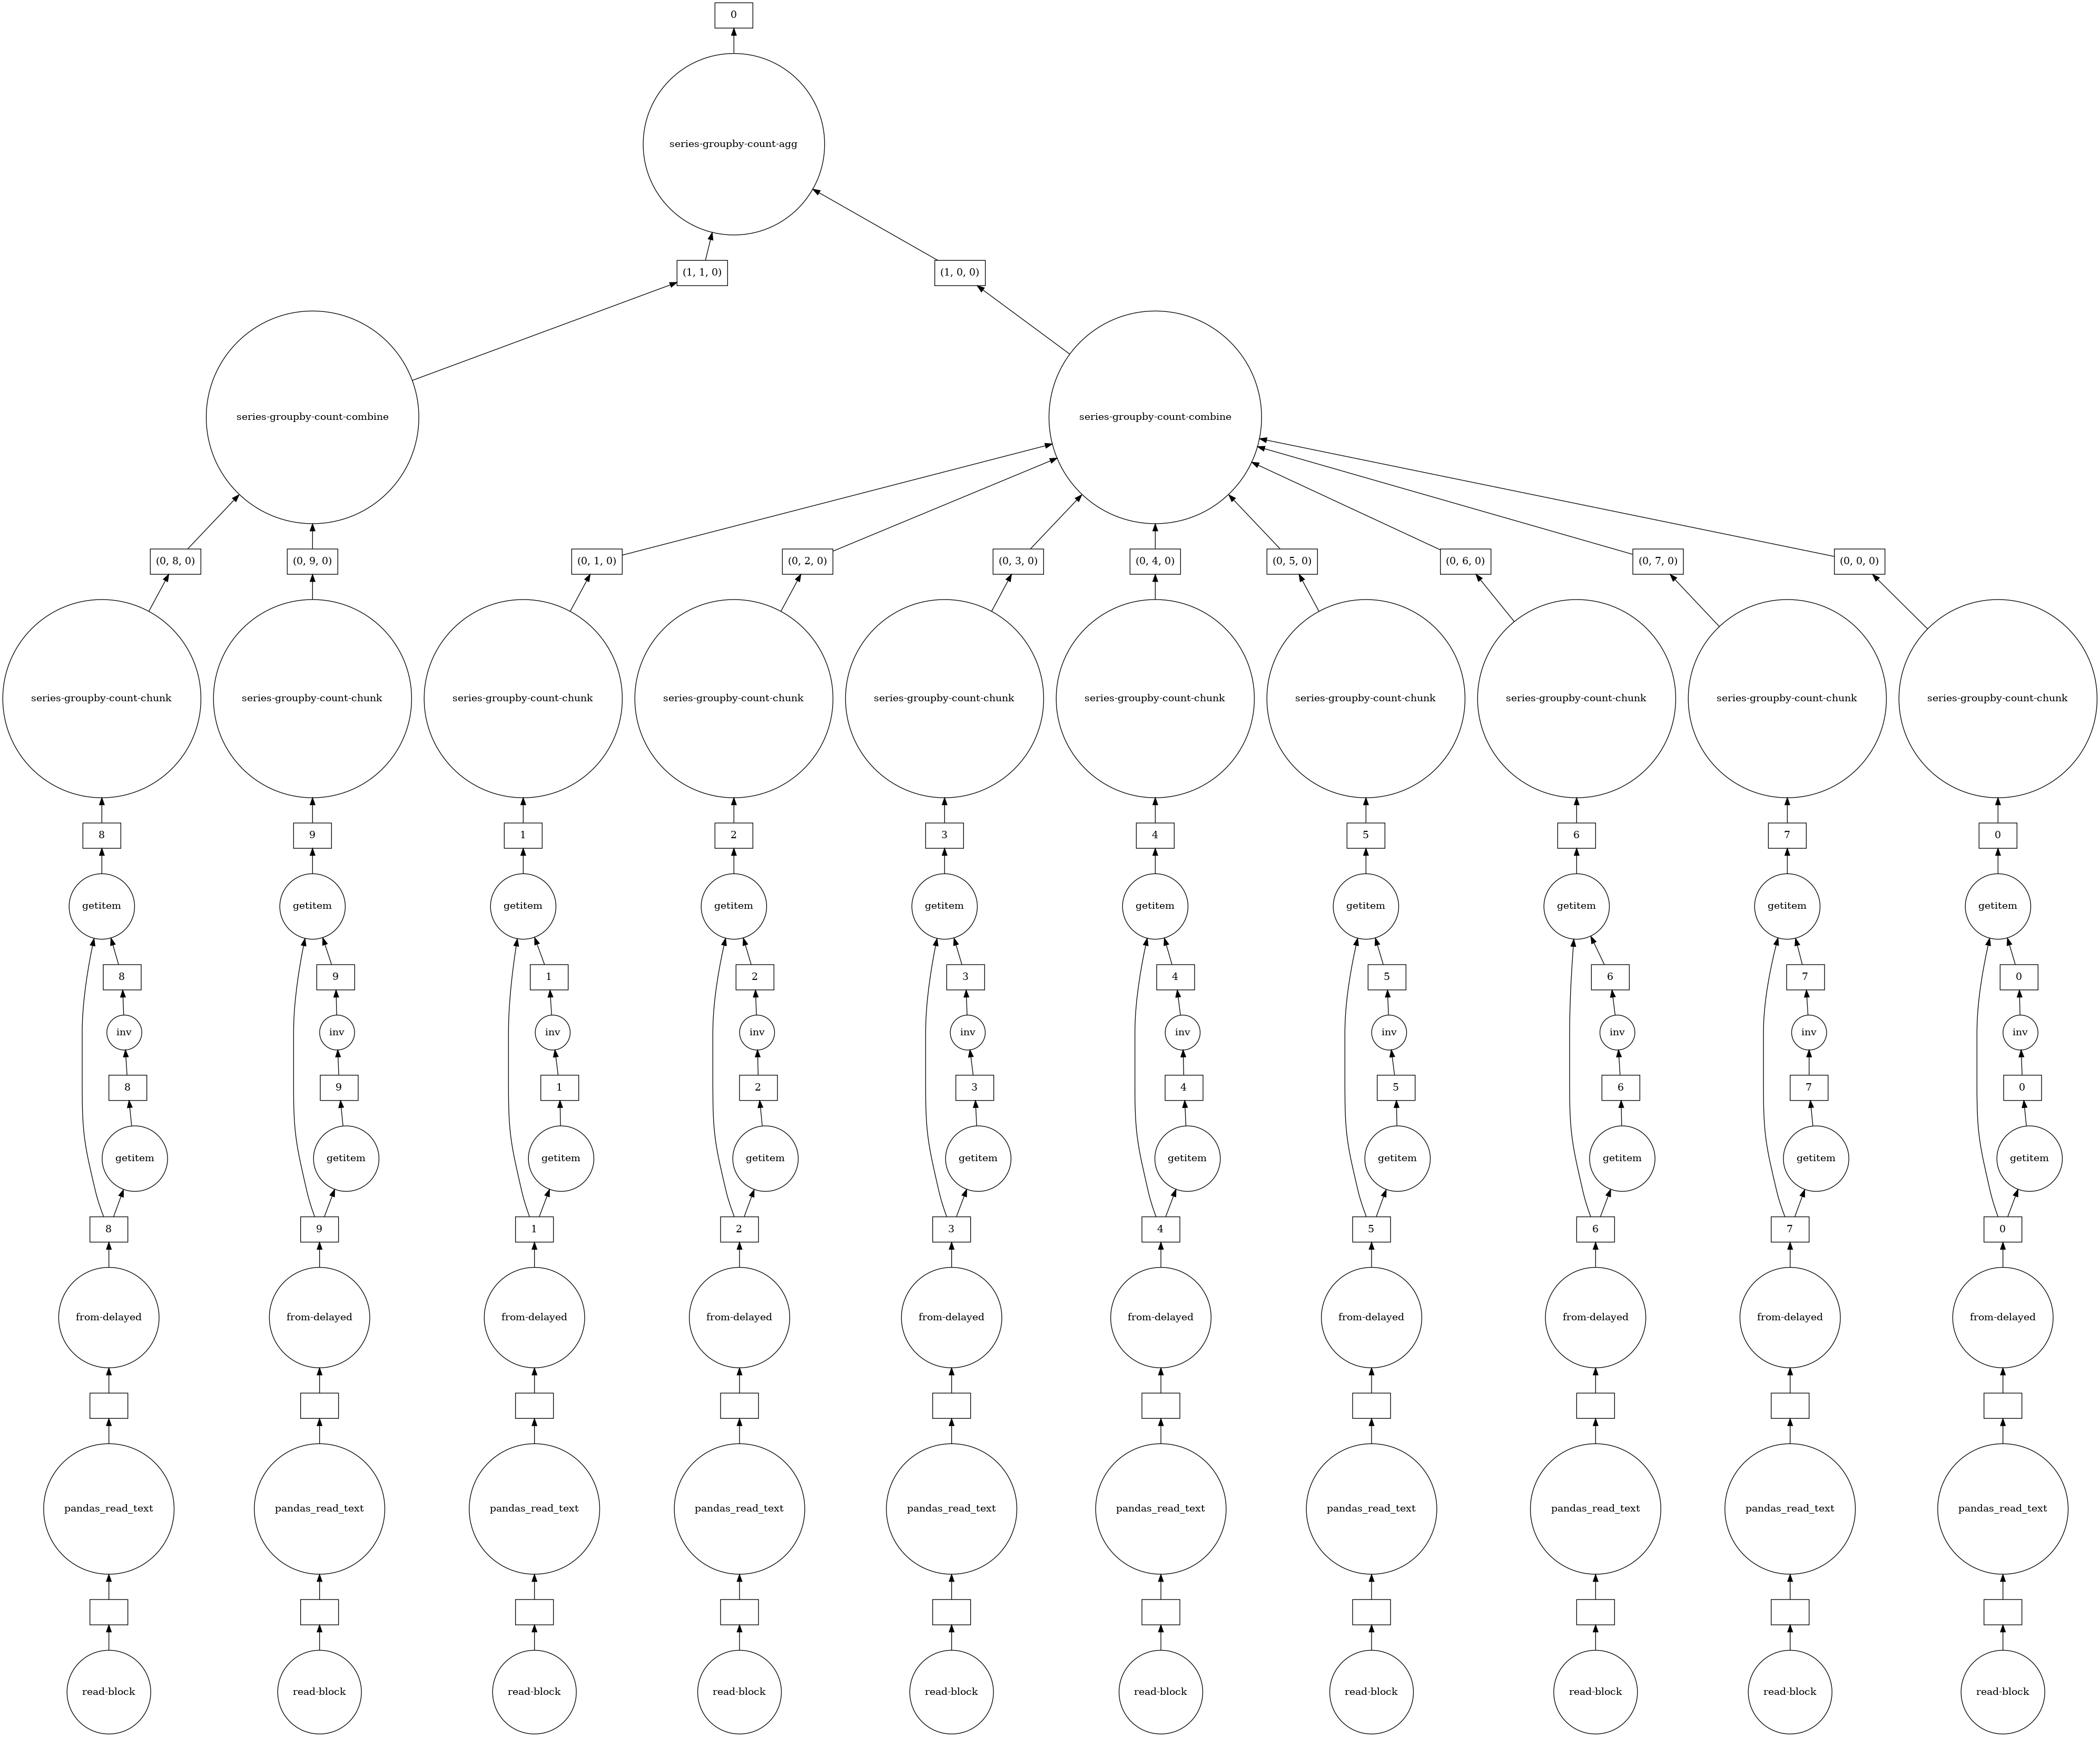

In [84]:
df[~df.Cancelled].groupby('Origin').Origin.count().visualize()

In [85]:
df.groupby("Origin").DepDelay.mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [86]:
df.columns

Index(['Date', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted'],
      dtype='object')

In [87]:
df.groupby("DayOfWeek").DepDelay.mean().compute()

DayOfWeek
1     8.096565
2     8.149109
3     9.141912
4    10.538275
5    11.476687
6     7.824071
7     8.994296
Name: DepDelay, dtype: float64

## Sharing Intermediate Results

When computing all of the above, we sometimes did the same operation more than once. For most operations, dask.dataframe hashes the arguments, allowing duplicate computations to be shared, and only computed once.

For example, lets compute the mean and standard deviation for departure delay of all non-canceled flights:

In [88]:
non_cancelled = df[~df.Cancelled]
mean_delay = non_cancelled.DepDelay.mean()
std_delay = non_cancelled.DepDelay.std()

Since dask operations are lazy, those values aren't the final results yet. They're just the recipe require to get the result.

In [89]:
non_cancelled

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Two calls to compute


In [90]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 25.4 s, sys: 1.67 s, total: 27.1 s
Wall time: 10.9 s


## Once call

In [91]:
%%time

mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 12.7 s, sys: 717 ms, total: 13.4 s
Wall time: 5.44 s


Using dask.compute takes roughly 1/2 the time. This is because the task graphs for both results are merged when calling dask.compute, allowing shared operations to only be done once instead of twice. In particular, using dask.compute only does the following once:

- the calls to read_csv
- the filter (df[~df.Cancelled])
- some of the necessary reductions (sum, count)

To see what the merged task graphs between multiple results look like (and what's shared), you can use the dask.visualize function (we might want to use filename='graph.pdf' to zoom in on the graph better):

In [92]:
dask.visualize(mean_delay, std_delay,  filename='graph.pdf')


# Dask DataFrame Data Model

For the most part, a Dask DataFrame feels like a pandas DataFrame. So far, the biggest difference we've seen is that Dask operations are lazy; they build up a task graph instead of executing immediately (more details coming in Schedulers). This lets Dask do operations in parallel and out of core.
In Dask Arrays, we saw that a dask.array was composed of many NumPy arrays, chunked along one or more dimensions. It's similar for dask.dataframe: a Dask DataFrame is composed of many pandas DataFrames. For dask.dataframe the chunking happens only along the index.

![](https://camo.githubusercontent.com/349ed6d3048da7d324ef6fa8b07f66f5072ad2eb/687474703a2f2f6461736b2e7079646174612e6f72672f656e2f6c61746573742f5f696d616765732f6461736b2d646174616672616d652e737667)

We call each chunk a partition, and the upper / lower bounds are divisions. Dask can store information about the divisions. We'll cover this in more detail in Distributed DataFrames. For now, partitions come up when you write custom functions to apply to Dask DataFrames

## Converting CRSDepTime to a timestamp

This dataset stores timestamps as HHMM, which are read in as integers in read_csv:

In [93]:
crs_dep_time = df.CRSDepTime.head(10)
crs_dep_time

0    1540
1    1540
2    1540
3    1540
4    1540
5    1540
6    1540
7    1540
8    1540
9    1540
Name: CRSDepTime, dtype: int64

To convert these to timestamps of scheduled departure time, we need to convert these integers into pd.Timedelta objects, and then combine them with the Date column.
In pandas we'd do this using the pd.to_timedelta function, and a bit of arithmetic:


In [94]:
import pandas as pd

# Get the first 10 dates to complement our `crs_dep_time`
date = df.Date.head(10)

# Get hours as an integer, convert to a timedelta
hours = crs_dep_time // 100
hours_timedelta = pd.to_timedelta(hours, unit='h')

# Get minutes as an integer, convert to a timedelta
minutes = crs_dep_time % 100
minutes_timedelta = pd.to_timedelta(minutes, unit='m')

# Apply the timedeltas to offset the dates by the departure time
departure_timestamp = date + hours_timedelta + minutes_timedelta
departure_timestamp

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
5   1990-01-06 15:40:00
6   1990-01-07 15:40:00
7   1990-01-08 15:40:00
8   1990-01-09 15:40:00
9   1990-01-10 15:40:00
dtype: datetime64[ns]

In [95]:
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [96]:
df.UniqueCarrier.str.slice(2)


Dask Series Structure:
npartitions=10
    object
       ...
     ...  
       ...
       ...
Name: UniqueCarrier, dtype: object
Dask Name: str-slice, 50 tasks

## Custom code and Dask Dataframe

We could swap out pd.to_timedelta for dd.to_timedelta and do the same operations on the entire dask DataFrame. But let's say that Dask hadn't implemented a dd.to_timedelta that works on Dask DataFrames. What would you do then?

dask.dataframe provides a few methods to make applying custom functions to Dask DataFrames easier:

- map_partitions
- map_overlap
- reduction

Here we'll just be discussing map_partitions, which we can use to implement to_timedelta on our own:

In [98]:
# Look at the docs for `map_partitions`

help(df.CRSDepTime.map_partitions)

Help on method map_partitions in module dask.dataframe.core:

map_partitions(func, *args, **kwargs) method of dask.dataframe.core.Series instance
    Apply Python function on each DataFrame partition.
    
    Note that the index and divisions are assumed to remain unchanged.
    
    Parameters
    ----------
    func : function
        Function applied to each partition.
    args, kwargs :
        Arguments and keywords to pass to the function. The partition will
        be the first argument, and these will be passed *after*. Arguments
        and keywords may contain ``Scalar``, ``Delayed`` or regular
        python objects. DataFrame-like args (both dask and pandas) will be
        repartitioned to align (if necessary) before applying the function.
    meta : pd.DataFrame, pd.Series, dict, iterable, tuple, optional
        An empty ``pd.DataFrame`` or ``pd.Series`` that matches the dtypes
        and column names of the output. This metadata is necessary for
        many algorithm

The basic idea is to apply a function that operates on a DataFrame to each partition. In this case, we'll apply pd.to_timedelta.

In [99]:
hours = df.CRSDepTime // 100
# hours_timedelta = pd.to_timedelta(hours, unit='h')
hours_timedelta = hours.map_partitions(pd.to_timedelta, unit='h')

minutes = df.CRSDepTime % 100
# minutes_timedelta = pd.to_timedelta(minutes, unit='m')
minutes_timedelta = minutes.map_partitions(pd.to_timedelta, unit='m')

departure_timestamp = df.Date + hours_timedelta + minutes_timedelta

In [100]:
departure_timestamp

Dask Series Structure:
npartitions=10
    datetime64[ns]
               ...
         ...      
               ...
               ...
dtype: datetime64[ns]
Dask Name: add, 110 tasks

In [101]:
departure_timestamp.head()


0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
dtype: datetime64[ns]

## Exercise: Rewrite above to use a single call to map_partitions
    
This will be slightly more efficient than two separate calls, as it reduces the number of tasks in the graph.

In [102]:
def compute_departure_timestamp(df):
    hours = df.CRSDepTime // 100
    hours_timedelta = pd.to_timedelta(hours, unit='h')

    minutes = df.CRSDepTime % 100
    minutes_timedelta = pd.to_timedelta(minutes, unit='m')

    return df.Date + hours_timedelta + minutes_timedelta

departure_timestamp = df.map_partitions(compute_departure_timestamp)

In [103]:
departure_timestamp.head()

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
dtype: datetime64[ns]

# END DATA FRAMES SECTION ------------

# Schedulers

In the previous notebooks, we used dask.delayed and dask.dataframe to parallelize computations. These work by building a task graph instead of executing immediately. Each task represents some function to call on some data, and the full graph is the relationship between all the tasks.

When we wanted the actual result, we called compute, which handed the task graph off to a scheduler.

Schedulers are responsible for running a task graph and producing a result.

![](https://camo.githubusercontent.com/4ec66b32adea7f0c68161f71279e15c82f69606a/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6461736b2f6461736b2d6f72672f6d61737465722f696d616765732f677269645f7365617263685f7363686564756c652e676966)

First, there are the single machine schedulers that execute things in parallel using threads or processes (or synchronously for debugging). These are what we've used up until now. Second, there's the dask.distributed scheduler, which is newer and has more features than the single machine scheduler.
In this notebook we'll first talk about the different schedulers. Then we'll use the dask.distributed scheduler in more depth.

# Local Schedulers

Dask separates computation description (task graphs) from execution (schedulers). This allows you to write code once, and run it locally or scale it out across a cluster.

Here we discuss the local schedulers - schedulers that run only on a single machine. The three options here are:

- dask.threaded.get         # uses a local thread pool
- dask.multiprocessing.get  # uses a local process pool
- dask.get                  # uses only the main thread (useful for debugging)

In each case we change the scheduler used in a few different ways:

- By providing a get= keyword argument to compute:

```python
total.compute(get=dask.multiprocessing.get)
# or 
dask.compute(a, b, get=dask.multiprocessing.get)
```

- Using dask.set_options:
    
```python
# Use multiprocessing in this block
with dask.set_options(get=dask.multiprocessing.get):
    total.compute()
# Use multiprocessing globally
dask.set_options(get=dask.multiprocessing.get)
```




Note: on master, we've also added a scheduler= keyword to compute that takes in scheduler names instead of scheduler functions. In future releases dask.compute(..., scheduler='threads') or dask.set_options(scheduler='threads') will be the preferred methods.

In [106]:
import os
import dask.dataframe as dd

In [107]:
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': object,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

# Maximum non-cancelled delay
largest_delay = df[~df.Cancelled].DepDelay.max()

In [108]:
largest_delay

dd.Scalar<series-..., dtype=float64>

In [109]:
%time _ = largest_delay.compute()  # this uses threads by default

CPU times: user 12.7 s, sys: 967 ms, total: 13.7 s
Wall time: 5.4 s


In [115]:
# NOT WORKING !!!
#%time _ = largest_delay.compute(scheduler='processes', num_workers=4)  # this uses processes

In [121]:
%time _ = largest_delay.compute()  # This uses a single thread


CPU times: user 12.8 s, sys: 1.08 s, total: 13.9 s
Wall time: 5.71 s


In [122]:
from multiprocessing import cpu_count
cpu_count()

16

In [138]:
# create a (local) cluster
# works well on single machine and is now preferrable (also better diagnostics)
from dask.distributed import Client
client = Client()

In [139]:
client

Client Scheduler: tcp://127.0.0.1:33535 Dashboard: http://127.0.0.1:35577/status,Cluster Workers: 4 Cores: 16 Memory: 134.85 GB
